In [12]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import seaborn as sns
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score)
from wordcloud import WordCloud
import random
import re

from sklearn.model_selection import train_test_split


nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/habkaffee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/habkaffee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# EDA

Setting seeds

In [13]:
seed = 42
random.seed(seed)
np.random.seed(seed)

In [20]:
def parse_dataset_to_sentences(path):
    sentences = []
    current = []
    tags = set()
    
    with open(path) as f:
        for line in f:
            if line.strip() == '<EOS>':
                sentences.append(current)
                current = []
                continue
            # splitted = line.split()
            # if splitted[0] not in stop_words:
            tags.add(line.split()[1])
            current.append(line.split())
        if len(current):
            sentences.append(current)
    return sentences, tags

In [21]:
parsed_data, tags = parse_dataset_to_sentences('data/rus.tsv')
tags

{'B-CARDINAL',
 'B-DATE',
 'B-EVENT',
 'B-FAC',
 'B-GPE',
 'B-LANGUAGE',
 'B-LOC',
 'B-MONEY',
 'B-NORP',
 'B-ORDINAL',
 'B-ORG',
 'B-PERCENT',
 'B-PERSON',
 'B-PRODUCT',
 'B-QUANTITY',
 'B-TIME',
 'B-WORK_OF_ART',
 'I-CARDINAL',
 'I-DATE',
 'I-EVENT',
 'I-FAC',
 'I-GPE',
 'I-LANGUAGE',
 'I-LOC',
 'I-MONEY',
 'I-NORP',
 'I-ORG',
 'I-PERCENT',
 'I-PERSON',
 'I-PRODUCT',
 'I-QUANTITY',
 'I-TIME',
 'I-WORK_OF_ART',
 'O'}

Tag description:
 - CARDINAL - Numerals that do not fall under another type
 - DATE - Absolute or relative dates or periods
 - EVENT - Named hurricanes, battles, wars, sports events, etc
 - FAC -Buildings, airports, highways, bridges, etc
 - GPE - Countries, cities, states
 - LANGUAGE - Any named language.
 - LOC - Non-GPE locations, mountain ranges, bodies of water
 - MONEY - Monetary values, including unit
 - NORP - Nationalities or religious or political groups
 - ORDINAL - “first”, “second”, etc.
 - ORG - Companies, agencies, institutions, etc
 - PERCENT - Percentage, including ”%“.
 - PERSON - People, including fictional
 - PRODUCT - Objects, vehicles, foods, etc. (Not services.)
 - QUANTITY - Measurements, as of weight or distance
 - TIME - Times smaller than a day
 - WORK_OF_ART - Titles of books, songs, etc
 - O - other (no named entity)

In [22]:
tts_ratio = 0.25
train, test = train_test_split(parsed_data, test_size=tts_ratio)
print(f'Train/test ratio -> {tts_ratio}\nTrain size -> {len(train)}\nTest size -> {len(test)}\nTotal size -> {len(train) + len(test)}')

Train/test ratio -> 0.25
Train size -> 993
Test size -> 331
Total size -> 1324


In [23]:
def get_quantity_per_tag(data, tags):
    labels = {label : 0 for label in tags}
    for sentence in data:
        for ent in sentence:
            labels[ent[1]] += 1
    return labels

In [24]:
train_distrib = get_quantity_per_tag(train, tags)
test_distrib = get_quantity_per_tag(test, tags)

In [25]:
train_distrib

{'B-CARDINAL': 185,
 'I-PERCENT': 23,
 'I-FAC': 19,
 'B-FAC': 37,
 'B-PRODUCT': 4,
 'I-LANGUAGE': 1,
 'I-TIME': 51,
 'I-ORG': 282,
 'B-PERSON': 496,
 'B-PERCENT': 24,
 'I-PERSON': 368,
 'I-PRODUCT': 2,
 'B-NORP': 195,
 'B-ORG': 480,
 'B-WORK_OF_ART': 8,
 'B-LANGUAGE': 1,
 'I-LOC': 46,
 'I-QUANTITY': 17,
 'I-DATE': 303,
 'B-MONEY': 35,
 'I-GPE': 48,
 'B-TIME': 40,
 'I-EVENT': 21,
 'B-QUANTITY': 16,
 'B-LOC': 79,
 'I-NORP': 2,
 'B-GPE': 621,
 'O': 18039,
 'I-CARDINAL': 24,
 'I-WORK_OF_ART': 6,
 'B-DATE': 314,
 'B-ORDINAL': 71,
 'B-EVENT': 13,
 'I-MONEY': 76}

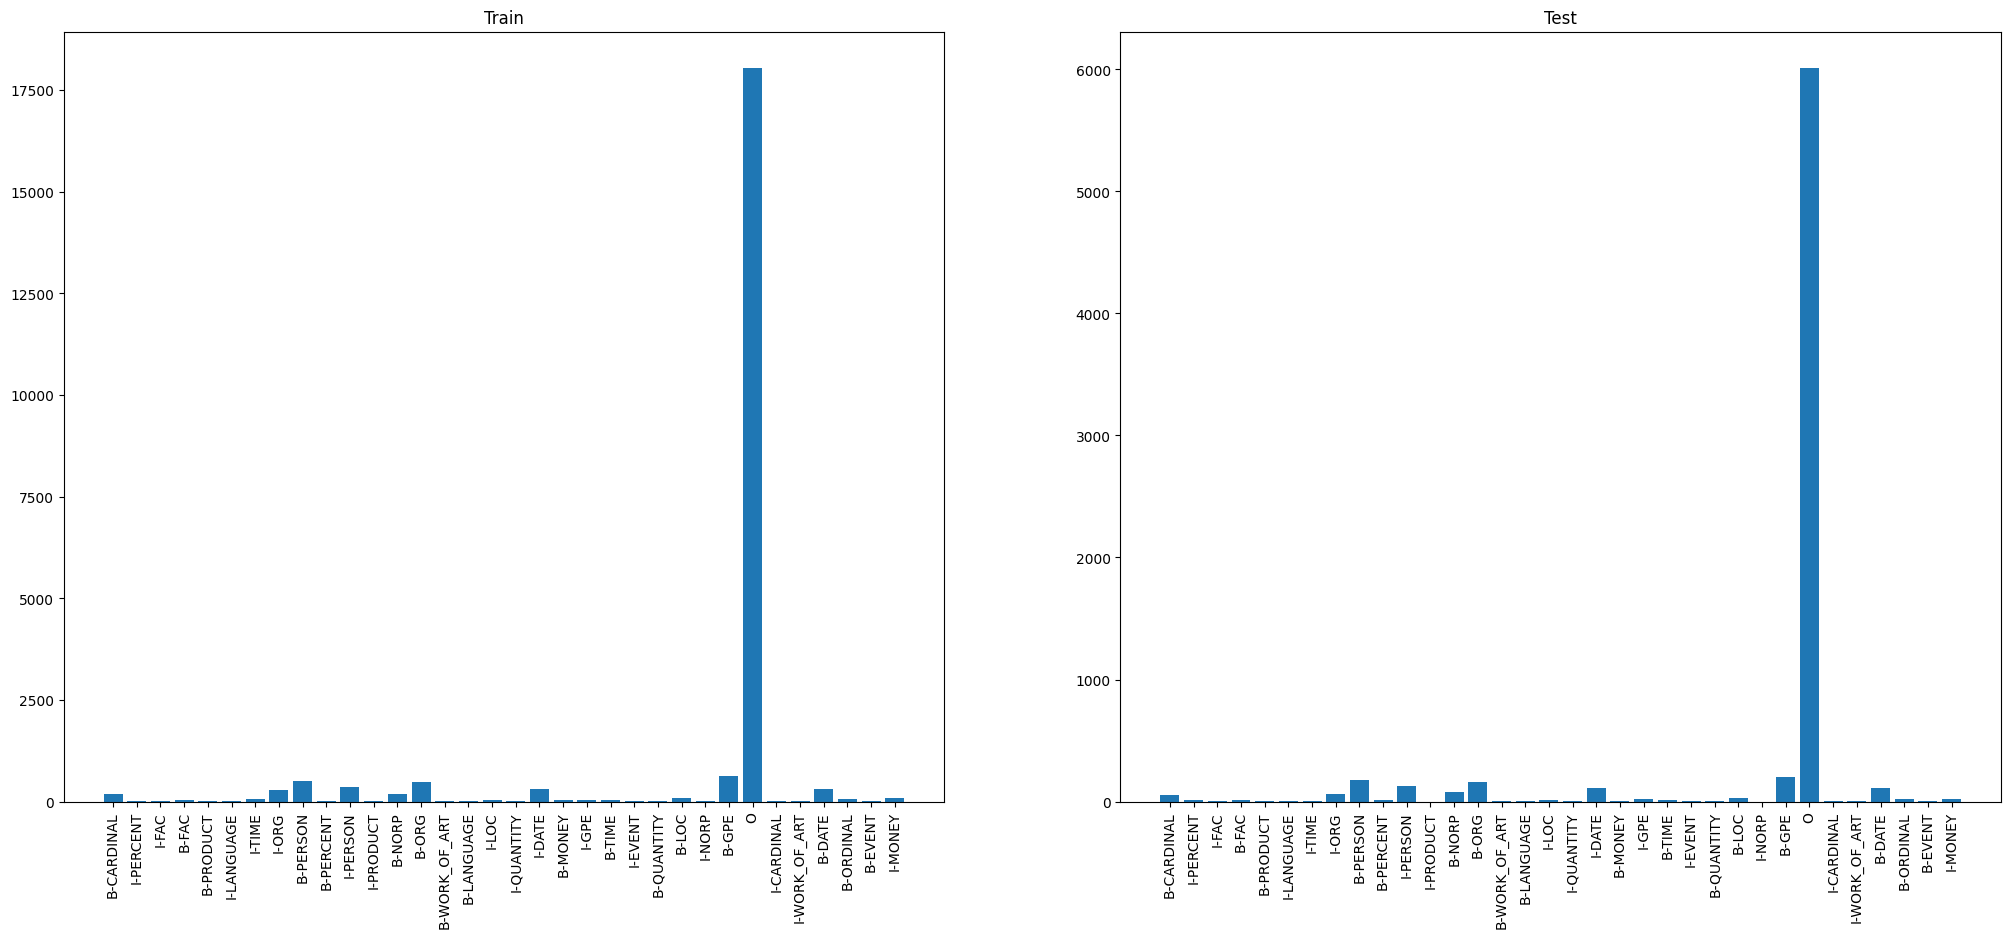

In [26]:
fig, axes = plt.subplots(1,2, figsize=(25,10))
datasets = [train_distrib, test_distrib]
titles = ['Train', 'Test']
for i, ax in enumerate(axes):
    ax.bar(
        x=list(datasets[i].keys()),
        height=list(datasets[i].values())
    )
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_title(titles[i])
plt.show()

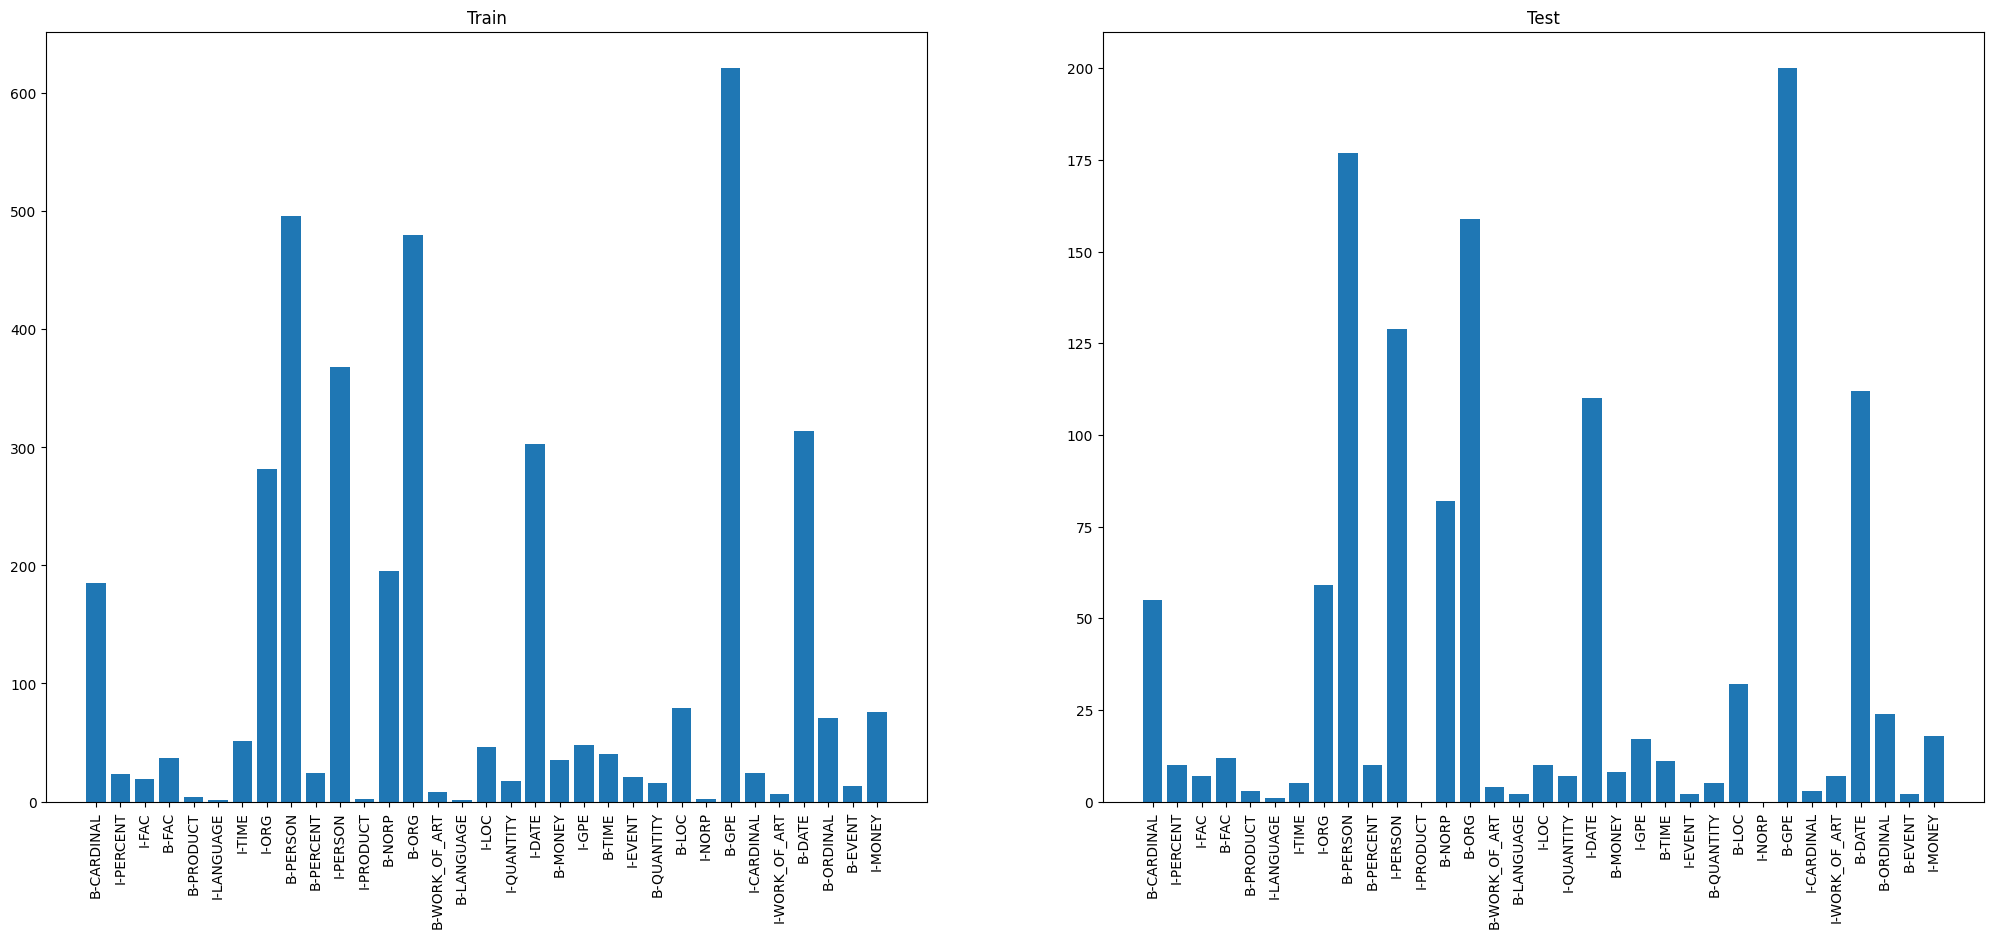

In [27]:
fig, axes = plt.subplots(1,2, figsize=(25,10))
train_distrib_named_only = train_distrib
test_distrib_named_only = test_distrib
train_distrib_named_only.pop('O')
test_distrib_named_only.pop('O')
datasets = [train_distrib_named_only, test_distrib_named_only]
titles = ['Train', 'Test']
for i, ax in enumerate(axes):
    ax.bar(
        x=list(datasets[i].keys()),
        height=list(datasets[i].values()),
        
    )
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_title(titles[i])
plt.show()

In [34]:
train_starts = {
    'CARDINAL' : {'B':0,'I':0},
    'DATE' : {'B':0,'I':0},
    'EVENT' : {'B':0,'I':0},
    'FAC' : {'B':0,'I':0},
    'GPE' : {'B':0,'I':0},
    'LANGUAGE' : {'B':0,'I':0},
    'LOC' : {'B':0,'I':0},
    'MONEY' : {'B':0,'I':0},
    'NORP' : {'B':0,'I':0},
    'ORG' : {'B':0,'I':0},
    'ORDINAL' : {'B':0,'I':0},
    'PERCENT' : {'B':0,'I':0},
    'PERSON' : {'B':0,'I':0},
    'PRODUCT' : {'B':0,'I':0},
    'QUANTITY' : {'B':0,'I':0},
    'TIME' : {'B':0,'I':0},
    'WORK_OF_ART' : {'B':0,'I':0},
}
test_starts = {
    'CARDINAL' : {'B':0,'I':0},
    'DATE' : {'B':0,'I':0},
    'EVENT' : {'B':0,'I':0},
    'FAC' : {'B':0,'I':0},
    'GPE' : {'B':0,'I':0},
    'LANGUAGE' : {'B':0,'I':0},
    'LOC' : {'B':0,'I':0},
    'MONEY' : {'B':0,'I':0},
    'NORP' : {'B':0,'I':0},
    'ORG' : {'B':0,'I':0},
    'ORDINAL' : {'B':0,'I':0},
    'PERCENT' : {'B':0,'I':0},
    'PERSON' : {'B':0,'I':0},
    'PRODUCT' : {'B':0,'I':0},
    'QUANTITY' : {'B':0,'I':0},
    'TIME' : {'B':0,'I':0},
    'WORK_OF_ART' : {'B':0,'I':0},
}

In [35]:
for key in train_distrib_named_only.keys():
    key_str = key[2:]
    train_starts[key_str][key[0]] += train_distrib_named_only[key]
train_starts

{'CARDINAL': {'B': 185, 'I': 24},
 'DATE': {'B': 314, 'I': 303},
 'EVENT': {'B': 13, 'I': 21},
 'FAC': {'B': 37, 'I': 19},
 'GPE': {'B': 621, 'I': 48},
 'LANGUAGE': {'B': 1, 'I': 1},
 'LOC': {'B': 79, 'I': 46},
 'MONEY': {'B': 35, 'I': 76},
 'NORP': {'B': 195, 'I': 2},
 'ORG': {'B': 480, 'I': 282},
 'ORDINAL': {'B': 71, 'I': 0},
 'PERCENT': {'B': 24, 'I': 23},
 'PERSON': {'B': 496, 'I': 368},
 'PRODUCT': {'B': 4, 'I': 2},
 'QUANTITY': {'B': 16, 'I': 17},
 'TIME': {'B': 40, 'I': 51},
 'WORK_OF_ART': {'B': 8, 'I': 6}}

In [36]:
for key in test_distrib_named_only.keys():
    key_str = key[2:]
    test_starts[key_str][key[0]] += test_distrib_named_only[key]
test_starts

{'CARDINAL': {'B': 55, 'I': 3},
 'DATE': {'B': 112, 'I': 110},
 'EVENT': {'B': 2, 'I': 2},
 'FAC': {'B': 12, 'I': 7},
 'GPE': {'B': 200, 'I': 17},
 'LANGUAGE': {'B': 2, 'I': 1},
 'LOC': {'B': 32, 'I': 10},
 'MONEY': {'B': 8, 'I': 18},
 'NORP': {'B': 82, 'I': 0},
 'ORG': {'B': 159, 'I': 59},
 'ORDINAL': {'B': 24, 'I': 0},
 'PERCENT': {'B': 10, 'I': 10},
 'PERSON': {'B': 177, 'I': 129},
 'PRODUCT': {'B': 3, 'I': 0},
 'QUANTITY': {'B': 5, 'I': 7},
 'TIME': {'B': 11, 'I': 5},
 'WORK_OF_ART': {'B': 4, 'I': 7}}

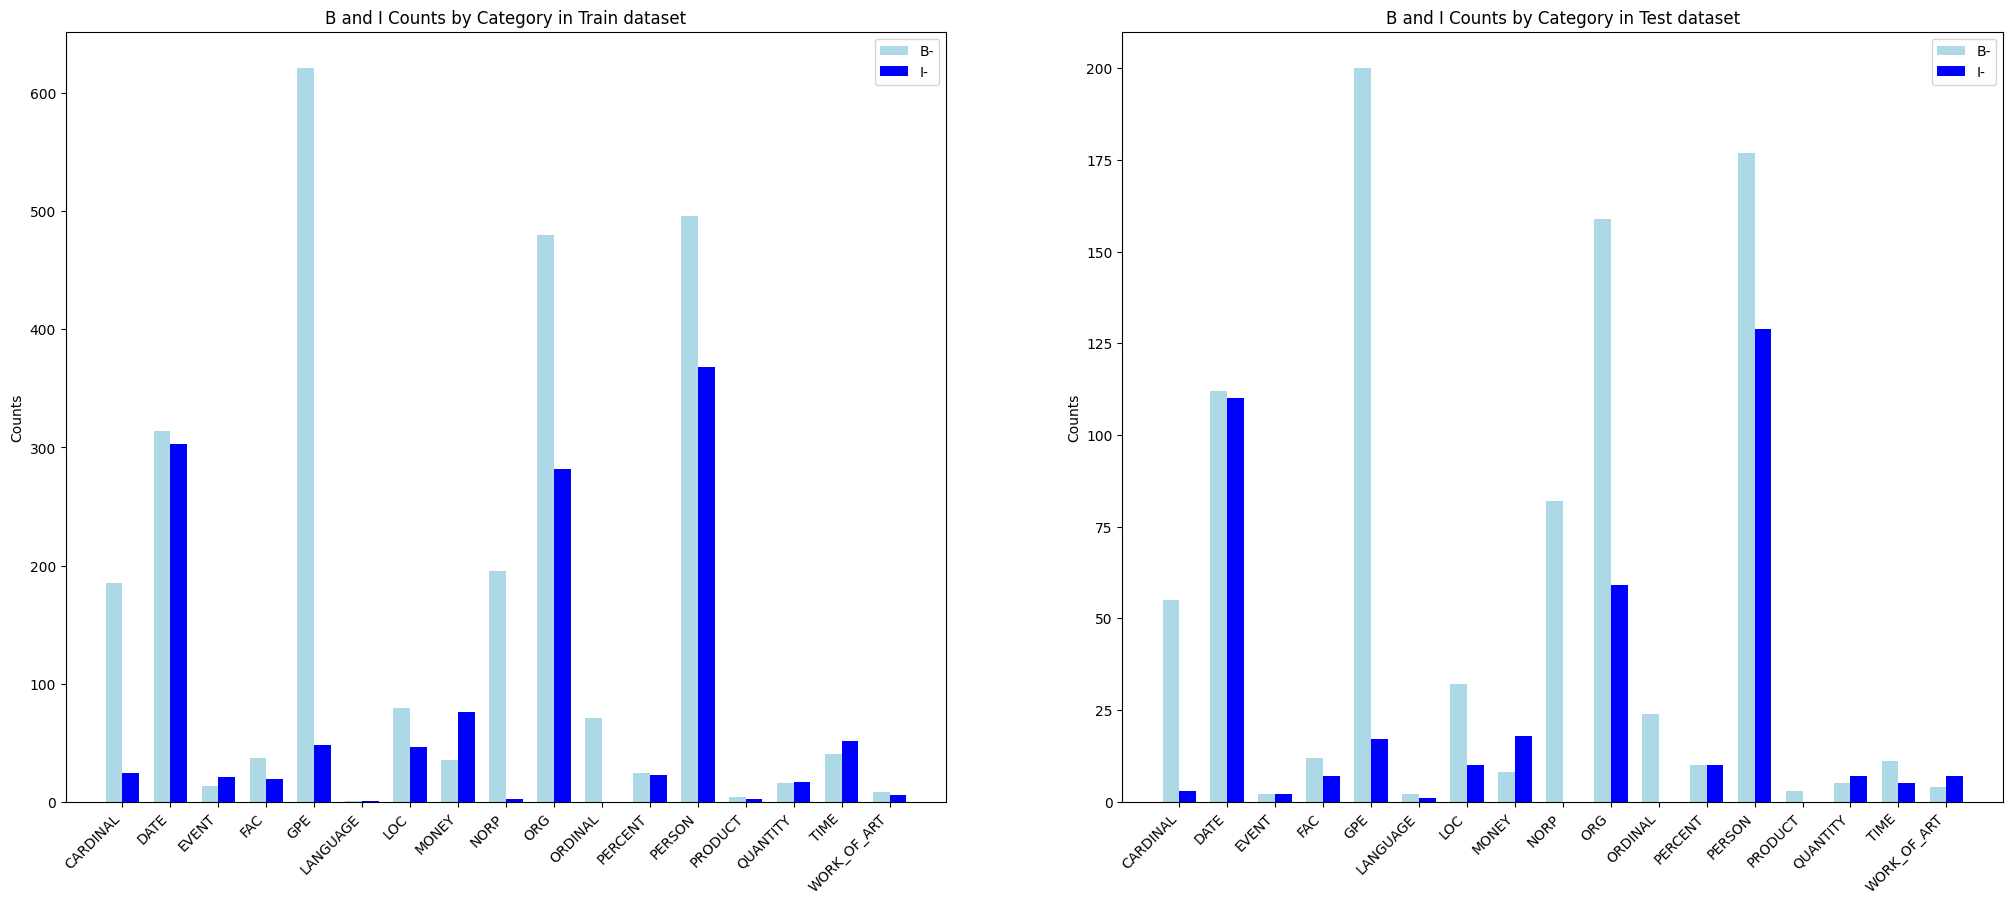

In [41]:
fig, axes = plt.subplots(1,2, figsize=(25,10))

datasets = [train_starts, test_starts]
titles = ['Train', 'Test']
for i, ax in enumerate(axes):
    categories = list(datasets[i].keys())
    B_values = [datasets[i][cat]['B'] for cat in categories]
    I_values = [datasets[i][cat]['I'] for cat in categories]
    width = 0.35
    x = np.arange(len(categories))
    rects1 = ax.bar(x - width/2, B_values, width, label='B-', color='lightblue')
    rects2 = ax.bar(x + width/2, I_values, width, label='I-', color='blue')
    ax.set_ylabel('Counts')
    ax.set_title(f'B and I Counts by Category in {titles[i]} dataset')
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.legend()
plt.show()

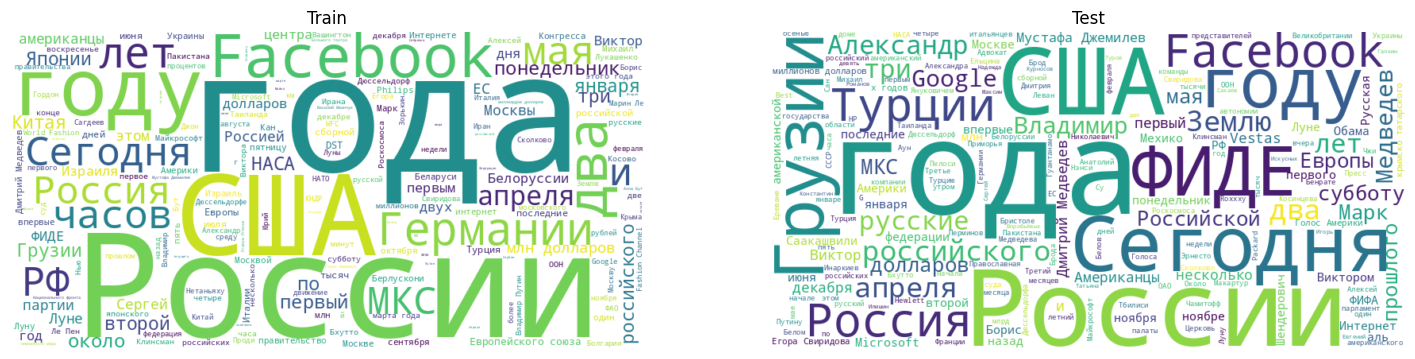

In [28]:
datasets = [train, test]
titles = ['Train', 'Test']
fig, axes = plt.subplots(1, len(datasets), figsize=(18,6))
for i in range(len(datasets)):
    text = " ".join([token for sentence in datasets[i] for token, label in sentence if label != 'O'])

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(titles[i])
plt.show()

# Rule-based approach

In [87]:
import spacy
from spacy.pipeline import EntityRuler

rule_based_model = spacy.load('ru_core_news_md')

ruler = rule_based_model.add_pipe("entity_ruler", before="ner")

# Define patterns
patterns = [
    {"label": "ORDINAL", "pattern": [{"LOWER": {"REGEX": "^(первый|второй|третий|четвёртый|пятый|шестой|седьмой|восьмой|девятый|нулевой)$"}}]},
    {"label": "ORDINAL", "pattern": [{"TEXT": {"REGEX": "^\\d+-й$"}}]},
    {"label": "CARDINAL", "pattern": [{"TEXT": {"REGEX": "^\\d+$"}}]},
    {"label": "DATE", "pattern": [{"TEXT": {"REGEX": "\\d{2}\\.\\d{2}\\.\\d{4}"}}]},
    {"label": "DATE", "pattern": [{"TEXT": {"REGEX": "\\d{1,2} \\w+ \\d{4}"}}]},
    {"label": "EVENT", "pattern": [{"LOWER": {"IN": ["Новогодние каникулы", "Рождество Христово", 
                                                     "День защитника Отечества", "Международный женский день",
                                                     "Праздник Весны и Труда", "День Победы", 
                                                     "День России", "День народного единства"]}}]},
    {"label": "FAC", "pattern": [{"TEXT": {"REGEX": "^[А-Я][а-я]+ский мост$"}}]},
    {"label": "FAC", "pattern": [{"TEXT": {"REGEX": "^[А-Я][а-я]+ская башня$"}}]},
    {"label": "GPE", "pattern": [{"TEXT": {"REGEX": "США|Росси[а-я]+|Япони[а-я]+|Москв[а-я]+|Грузи[а-я]+|ЕС"}}]},
    {"label": "LANGUAGE", "pattern": [{"LOWER": {"IN": ["русский", "английский", "китайский", "французский", "японский"]}}]},
    {"label": "LOC", "pattern": [{"TEXT": {"REGEX": "^[А-Я][а-я]+ (гор[а-я]*|рек[а-я]|озер[а-я])$"}}]},
    {"label": "LOC", "pattern": [{"TEXT": {"REGEX": "^река [А-Я][а-я]+$"}}]},
    {"label": "MONEY", "pattern": [{"TEXT": {"REGEX": "^\\d+ руб\\.$"}}]},
    {"label": "MONEY", "pattern": [{"TEXT": {"REGEX": "^\\d+\\s+₽$"}}]},
    {"label": "NORP", "pattern": [{"LOWER": {"IN": ["русский", "немец", "еврей",
                                                    "грузин", "японец", "русская",
                                                    "немка", "еврейка", "грузинка",
                                                    "японка", "православный", "мусульманин",
                                                    "православная", "мусульманка"]}}]},
    {"label": "ORG", "pattern": [{"TEXT": {"REGEX": "^[А-Я][а-я]+[-]*банк$"}}]},
    {"label": "ORG", "pattern": [{"LOWER": {"IN": ["газпром", "яндекс", "озон", "магнит", "пятерочка"]}}]},
    {"label": "PERCENT", "pattern": [{"TEXT": {"REGEX": "^\\d+%$"}}]},
    {"label": "PERCENT", "pattern": [{"TEXT": {"REGEX": "^\\d+ проц\\.$"}}]},
    {"label": "PERSON", "pattern": [{"TEXT": {"REGEX": "^[А-ЯЁ][а-яё]+ [А-ЯЁ][а-яё]+$"}}]},
    {"label": "PERSON", "pattern": [{"TEXT": {"REGEX": "^(г-н|г-жа|тов\\.)? ?[А-ЯЁ][а-яё]+ [А-ЯЁ][а-яё]+$"}}]},
    {"label": "PERSON", "pattern": [{"TEXT": {"REGEX": "^[А-ЯЁ][а-яё]+ [А-ЯЁ][а-яё]+( [А-ЯЁ][а-яё]+)?$"}}]},
    {"label": "PRODUCT", "pattern": [{"TEXT": {"REGEX": "^[А-Я][а-я]+фон$"}}]},
    {"label": "PRODUCT", "pattern": [{"TEXT": {"REGEX": "^[А-Я][а-я]+ный товар$"}}]},
    {"label": "QUANTITY", "pattern": [{"TEXT": {"REGEX": "^\\d+ [к|м]*г$"}}]},
    {"label": "QUANTITY", "pattern": [{"TEXT": {"REGEX": "^\\d+ [милли]*литров$"}}]},
    {"label": "TIME", "pattern": [{"TEXT": {"REGEX": "^\\d+:\\d+$"}}]},
    {"label": "TIME", "pattern": [{"TEXT": {"REGEX": "^\\d+ [секунд|минут|часов]$"}}]},
    {"label": "WORK_OF_ART", "pattern": [{"TEXT": {"REGEX": "^[«\"]\\w+[»\"]$"}}]},
    {"label": "WORK_OF_ART", "pattern": [{"TEXT": {"REGEX": "^[А-Я][а-я]+ \\w+$"}}]},
]

# Add patterns to the ruler
ruler.add_patterns(patterns)

# default_pattern = {"label": "DEFAULT", "pattern": [{"TEXT": {"REGEX": ".+"}}]}
# ruler.add_patterns([default_pattern])

In [95]:
doc = rule_based_model(' '.join([i[0] for i in test[0]]))

# Display entities
for ent in doc.ents:
    print(f"{ent.text}: {ent.label_}")


from spacy import displacy

# Visualize entities
displacy.render(doc, style="ent", jupyter=True)

России: GPE
Константин Сакаев: PER
2637: CARDINAL
Александр Галкин: PER
2618: CARDINAL
Владимир Белов: PER
2599: CARDINAL
Эрнесто Инаркиев: PER
2602: CARDINAL
Максим Туров: PER
2539: CARDINAL
Игорь Курносов: PER
2526: CARDINAL
Сергей Искусных: PER
2510: CARDINAL
Алексей Илюшин: PER
2483: CARDINAL
Евгений Романов: PER
2480: CARDINAL
Надежда Косинцева: PER
2469: CARDINAL
Татьяна Косинцева: PER
2489: CARDINAL


In [120]:
def calculate_metrics(data, model):
    metrics = {
        'accuracy' : 0,
        'precision' : 0,
        'recall' : 0,
        'f1_macro' : 0
    }
    all_y_true = []
    all_y_pred = []
    for sentence in data:
        model_resp = model(' '.join(word[0] for word in sentence))
        y_pred = []
        y_true = []
        for token in model_resp:
            y_pred.append(token.ent_type_ if token.ent_type_ else 'O')
        for word in sentence:
            y_true.append(word[1])
        all_y_true.append(y_true)
        all_y_pred.append(y_pred)
    metrics['accuracy'] = accuracy_score(all_y_true, all_y_pred)
    metrics['precision'] = precision_score(all_y_true, all_y_pred, average='macro')
    metrics['recall'] = recall_score(all_y_true, all_y_pred, average='macro')
    metrics['f1_macro'] = f1_score(all_y_true, all_y_pred, average='macro')
    return metrics

In [119]:
accuracy, precision, recall, f1 = calculate_metrics([test[0]], rule_based_model)
accuracy, precision, recall, f1

ValueError: multiclass-multioutput is not supported